# 序列到序列学习（seq2seq）

In [2]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, ​**kwargs):
        # 初始化父类（继承自d2l.Encoder框架）
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 创建词嵌入层：将词汇索引转换为密集向量
        # vocab_size: 输入语言词汇表大小（如10000个词）
        # embed_size: 每个词向量的维度（如512维）
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 创建GRU循环神经网络层
        # embed_size: 输入特征维度（与嵌入层输出一致）
        # num_hiddens: 隐藏层神经元数（如24个）
        # num_layers: GRU堆叠层数（如2层）
        # dropout: 层间随机失活率（防止过拟合）
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输入X形状：(batch_size, seq_length) 如(3,8)
        
        # 嵌入层处理：将词索引转换为密集向量
        # 输出形状变为：(batch_size, seq_length, embed_size) 如(3,8,512)
        X = self.embedding(X)
        
        # 维度置换：调整张量维度顺序以适应RNN输入要求
        # permute(1,0,2)将维度从(batch,seq,embed)变为(seq,batch,embed)
        # 因为PyTorch的RNN层要求输入形状为(seq_len, batch_size, input_size)
        X = X.permute(1, 0, 2)
        
        # 通过GRU网络处理时序数据
        # output: 所有时间步的隐藏状态，形状(seq_len, batch_size, num_hiddens*D) 
        #         D=1（单向）或2（双向），此处默认单向
        # state: 最后一个时间步的隐藏状态，形状(num_layers, batch_size, num_hiddens)
        #        当num_layers=2时包含两个隐藏层的最终状态
        output, state = self.rnn(X)
        
        # 返回编码器输出和最终状态（供解码器初始化用）
        return output, state

In [6]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [8]:
state.shape

torch.Size([2, 4, 16])

In [10]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, ​**kwargs):
        # 初始化父类（继承自d2l.Decoder框架）
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        # 创建词嵌入层：将目标语言词索引转换为密集向量
        # vocab_size: 目标语言词汇表大小（如25000个词）
        # embed_size: 每个词向量的维度（需与编码器设置一致）
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 创建带上下文拼接的GRU网络：
        # 输入维度是embed_size + num_hiddens（将编码器上下文信息与当前词向量拼接）
        # num_hiddens: 隐藏层维度需与编码器一致（如24）
        # num_layers: GRU层数需与编码器一致（如2层）
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        # 输出全连接层：将隐藏状态映射到目标语言词汇表维度
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        # 从编码器输出中提取最终隐藏状态作为解码器初始状态
        # enc_outputs是元组(output, state)，其中state包含各层的最终隐藏状态
        # 取[1]索引获取state，该状态是(num_layers, batch_size, num_hiddens)
        return enc_outputs[1]

    def forward(self, X, state):
        # 输入X形状：(batch_size, seq_length) 如(3,7)
        # 词嵌入处理，输出形状变为：(batch_size, seq_length, embed_size)
        X = self.embedding(X)
        # 维度置换：调整为(seq_length, batch_size, embed_size)
        # 与编码器一致，满足PyTorch GRU输入格式要求
        X = X.permute(1, 0, 2)
        # 上下文扩展：获取编码器最后时刻最后一层的隐藏状态
        # state[-1]的shape是(num_layers, batch_size, num_hiddens)，取最后一层
        # repeat扩展至(seq_length, batch_size, num_hiddens)匹配时间步数
        context = state[-1].repeat(X.shape[0], 1, 1)
        # 拼接词向量与上下文信息
        # 在特征维度拼接，因此输入维度变为embed_size+num_hiddens
        X_and_context = torch.cat((X, context), 2)
        # GRU前向传播（同时传递初始状态）
        # output形状：(seq_length, batch_size, num_hiddens)
        # state形状：(num_layers, batch_size, num_hiddens)
        output, state = self.rnn(X_and_context, state)
        # 全连接层预测词概率分布
        # 先permute恢复为(batch_size, seq_length, vocab_size)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [12]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [52]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项。"""
    # 获取当前批次的最大序列长度（X的形状是(batch_size, seq_length)）
    # 例如：X是形状(2,3)的张量时，maxlen=3
    maxlen = X.size(1)
    
    # 创建序列位置索引矩阵
    # torch.arange生成[0,1,2,...,maxlen-1]的行向量（通过[None,:]增加第0维度）
    # 与valid_len[:,None]（列向量）进行广播比较，生成布尔掩码矩阵
    # 例如valid_len=[1,2]时，生成mask=[[True,False,False],[True,True,False]]
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    
    # 将掩码取反后赋值为指定值
    # ~mask表示需要屏蔽的位置，例如mask为False的位置会被填充value
    X[~mask] = value
    
    return X  # 返回处理后的张量，如输入[[1,2,3],[4,5,6]]变为[[1,0,0],[4,5,0]]

"""
应用场景说明：
1. 自然语言处理：处理不同长度句子时屏蔽padding位置
2. 时间序列预测：仅对有效历史数据进行处理
3. 注意力机制：防止关注到无效位置

关键记忆点：
1. 维度操作技巧：
   - [None,:]将行向量变为(1, maxlen)
   - valid_len[:,None]将列向量变为(batch_size, 1)
   - 两者广播后得到(batch_size, maxlen)的布尔矩阵

2. 设备一致性原则：
   - mask.device = X.device 确保张量在同一设备（CPU/GPU）

3. 逆向思维运用：
   - 通过~mask取反选择需要屏蔽的位置

"""

'\n应用场景说明：\n1. 自然语言处理：处理不同长度句子时屏蔽padding位置\n2. 时间序列预测：仅对有效历史数据进行处理\n3. 注意力机制：防止关注到无效位置\n\n关键记忆点：\n1. 维度操作技巧：\n   - [None,:]将行向量变为(1, maxlen)\n   - valid_len[:,None]将列向量变为(batch_size, 1)\n   - 两者广播后得到(batch_size, maxlen)的布尔矩阵\n\n2. 设备一致性原则：\n   - mask.device = X.device 确保张量在同一设备（CPU/GPU）\n\n3. 逆向思维运用：\n   - 通过~mask取反选择需要屏蔽的位置\n\n'

In [16]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [18]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    def forward(self, pred, label, valid_len):
        # 初始化权重矩阵：创建与标签形状相同的全1张量
        # 原理：所有时间步初始权重为1，后续通过valid_len屏蔽padding位置
        # 记忆点：始终与label形状保持一致（batch_size, seq_length）
        weights = torch.ones_like(label)
        
        # 应用序列遮蔽：将超出有效长度的位置权重置0
        # 关键：sequence_mask函数
        # 效果：例如valid_len=[2,4]时，保留前2/4个时间步的权重
        weights = sequence_mask(weights, valid_len)
        
        # 禁用默认的损失聚合方式：保留每个时间步的损失值
        # 原理：父类CrossEntropyLoss默认会做mean/sum，这里需要逐个位置计算
        self.reduction = 'none'
        
        # 计算未加权的交叉熵损失（注意维度调整）
        # permute(0,2,1)将pred从(batch, seq, vocab)转为(batch, vocab, seq)
        # 原因：CrossEntropyLoss要求class维度在第二位置
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        
        # 应用权重并沿序列维度取平均
        # 数学原理：加权平均公式 (sum(loss * weight)) / sum(weight)
        # 实现技巧：mean(dim=1)对每个样本的序列维度做平均
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        
        return weighted_loss
"""
预测输出：[B,T,V] → permute → [B,V,T]  
交叉熵计算：与标签[B,T]对齐 → 得到未加权损失[B,T]
应用遮蔽权重[B,T] → 加权平均得到最终损失[B]
"""

In [20]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [44]:
import torch.optim as optim
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    # 初始化模型参数（Xavier初始化策略）
    def xavier_init_weights(m):
        # 原理：Xavier初始化保持各层激活值的方差稳定
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)  # 全连接层权重初始化
        if type(m) == nn.GRU:
            for param in m._flat_weights:
                if param.ndim == 2:
                    nn.init.xavier_uniform_(param)  # GRU的权重矩阵初始化
    
    # 应用初始化函数到所有网络层
    net.apply(xavier_init_weights)
    # 将模型移动到指定设备（CPU/GPU）
    net.to(device)
    
    # 设置优化器（Adam自适应学习率算法）
    optimizer = optim.Adam(net.parameters(), lr=lr)  
    
    # 定义带遮蔽的交叉熵损失函数（忽略padding位置）
    loss = d2l.MaskedSoftmaxCELoss()  
    
    # 切换到训练模式（影响dropout等层的状态）
    net.train()
    
    # 可视化工具初始化（监控训练过程）
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs])
    
    # 训练循环
    for epoch in range(num_epochs):
        timer = d2l.Timer()  # 计时工具
        metric = d2l.Accumulator(2)  # 累计损失和有效token数
        
        for batch in data_iter:
            # 数据预处理：将批量数据移动到指定设备
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            
            # 构建解码器输入：添加<bos>起始符
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 拼接起始符与右移后的目标序列
            
            # 前向传播：获取模型输出（编码器-解码器联合计算）
            output = net(X, dec_input, X_valid_len)
            
            # 处理网络输出：解包可能存在的元组结构（如包含注意力权重）
            if isinstance(output, tuple):
                Y_hat, _ = output  # 取预测结果部分
            else:
                Y_hat = output
            
            # 计算损失值（自动处理序列遮蔽）
            l = loss(Y_hat, Y, Y_valid_len)
            
            # 反向传播与梯度裁剪（防止梯度爆炸）
            l.sum().backward()  # 损失求和后反向传播
            d2l.grad_clipping(net, 1)  # 梯度裁剪阈值设为1（策略参考网页3的训练技巧）
            
            # 参数更新
            optimizer.step()  # 执行优化器更新步骤
            optimizer.zero_grad()  # 清空梯度（重要！防止梯度累积）
            
            # 累计统计指标
            metric.add(l.sum(), l.numel())  # 记录总损失和有效token数
        
        # 周期日志输出
        if (epoch + 1) % 10 == 0:
            # 计算平均损失和吞吐量
            print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
        animator.add(epoch + 1, (metric[0] / metric[1],))  # 更新训练曲线

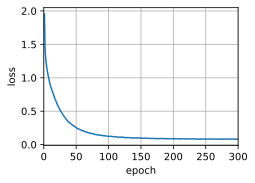

In [46]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [26]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 设置模型为评估模式（关闭dropout等训练专用层）
    net.eval()  # 原理：预测时不更新参数，保持计算图稳定
    
    # 将源语句转换为词索引序列，并添加结束符<eos>
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]  # 注意：lower()统一为小写，split()分词处理
    
    # 创建有效长度张量（实际序列长度）
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)  # 用于编码器掩码
    
    # 截断/填充处理：统一为固定长度num_steps
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])  # 填充<pad>符号
    
    # 添加批量维度（batch_size=1）并转换为设备张量
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)  # 形状从(seq_len,)变为(1, seq_len)
    
    # 编码器前向传播（获取上下文向量）
    enc_outputs = net.encoder(enc_X, enc_valid_len)  # 输出包含编码器各时间步状态
    
    # 初始化解码器状态（使用编码器最终隐藏状态）
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)  # 状态传递原理
    
    # 构建解码器初始输入（<bos>符号）
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)  # 形状(1,1)，启动解码过程
    
    # 初始化输出序列和注意力权重容器
    output_seq, attention_weight_seq = [], []
    
    # 循环生成目标序列（最多num_steps步）
    for _ in range(num_steps):
        # 解码器前向传播（Y形状：(1,1, vocab_size)）
        Y, dec_state = net.decoder(dec_X, dec_state)  # 当前时间步预测
        
        # 选择概率最高的词作为下一时间步输入（贪心搜索）
        dec_X = Y.argmax(dim=2)  # dim=2选择词汇维度，得到预测词索引
        
        # 提取预测词索引（去除批量维度）
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()  # 转为Python标量
        
        # 保存注意力权重（用于可视化）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)  # 注意力机制扩展点
        
        # 遇到结束符则终止生成
        if pred == tgt_vocab['<eos>']:  # 提前终止条件
            break
        
        # 收集预测结果
        output_seq.append(pred)  # 存储词索引序列
    
    # 将索引序列转换为目标语言词汇
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq  # 最终输出字符串

In [28]:
def bleu(pred_seq, label_seq, k):  
    """计算BLEU分数，评估机器翻译质量"""
    # 将预测序列和参考序列分割为词列表（处理基础单元）
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    # 获取预测序列和参考序列的长度（用于后续长度惩罚计算）
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    
    # 初始化长度惩罚因子（解决短句得分虚高问题）
    # 原理：当预测长度<参考长度时施加惩罚
    score = math.exp(min(0, 1 - len_label / len_pred))  # exp(min(0, 1 - r/c))
    
    # 遍历1到k元语法（n-gram）计算匹配度
    for n in range(1, k + 1):
        num_matches = 0  # 有效匹配次数计数器
        label_subs = collections.defaultdict(int)  # 存储参考n-gram的出现次数
        
        # 生成参考序列的所有n-gram并统计出现次数（用于修正精确度）
        for i in range(len_label - n + 1):
            ngram = ''.join(label_tokens[i:i + n])  # 拼接n-gram作为字典键
            label_subs[ngram] += 1  # 记录参考中n-gram出现次数
        
        # 检测预测序列中的n-gram匹配（考虑重复情况）
        for i in range(len_pred - n + 1):
            ngram = ''.join(pred_tokens[i:i + n])  
            if label_subs[ngram] > 0:  # 当参考中存在该n-gram时
                num_matches += 1  # 增加有效匹配计数
                label_subs[ngram] -= 1  # 避免重复匹配
        
        # 计算当前n-gram的修正精确度（分子：有效匹配数，分母：预测n-gram总数）
        precision = num_matches / (len_pred - n + 1)
        # 加权几何平均（权重系数为0.5^n，参考网页4的加权策略）
        score *= math.pow(precision, math.pow(0.5, n))
    
    return score  # 最终BLEU得分（范围0-1，值越大质量越好）

In [30]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => le les viens viens je je je je trouve je, bleu 0.000
i lost . => le cours je trouve trouve trouve trouve courez oublie-le oublie-le, bleu 0.000
he's calm . => le cours je trouve trouve trouve trouve courez oublie-le oublie-le, bleu 0.000
i'm home . => le les les j’ai j’ai parti oublie-le oublie-le soyez soyez, bleu 0.000
